# ФКН ВШЭ: Промышленная разработка

## Практическое задание 9. Анализ логов

### Общая информация
Дата лекции: 22.11.2021

Срок сдачи: до 06.12.2021

### Критерии оценивания:
Есть ссылка на книжку на github: +20

В книжке все сделано аккуратно, оформлено и прокомментировано: +20

Исследован исходный корпус логов и синтезирован новый корпус:  +20

Построен читаемый граф: +40


### Задача 1
Взять тестовый корпус и построить таблицу, которая описывает граф переходов.

Мы использовали книгу 20,000 Leagues Under the Sea, которую можно открыто скачать с сайта https://manybooks.net/titles/vernejuletext942000010.html#

In [1]:
import nltk

textfile = open('20000-Leagues-Under-the-Sea.txt','r')
book = textfile.read()

In [2]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

# Используем TweetTokenizer, так как он хорошо обрабатывает знаки пунктуации и сокращения (например, I'm)
tweet = TweetTokenizer()
tokens = tweet.tokenize(book.lower())

In [24]:
from tqdm.notebook import tqdm
import string
import re

# Выделим, какие буквы мы рассматриваем
punctuation=".,;\-!?\"\'() "
approved_letters = list(string.ascii_lowercase) + list(string.digits) + list(punctuation)
regex = re.compile('[^a-z1-9' + punctuation + ']')

# Построим очищенный текст на основе проделанной токенизации
clean_book = tokens[0]
for word in tqdm(tokens[1:]):
    if len(word) > 1 or word not in string.punctuation:
        clean_book += " "

    clean_book += regex.sub('', word)

In [25]:
import pandas as pd
import numpy as np
from nltk import bigrams

# Реализуем создание таблицы со статистикой
def prepare_connections_table(clean_text):
    global approved_letters
    
    # Создалим таблицу с счетчиками переходов букв
    connections = pd.DataFrame(np.zeros((len(approved_letters), len(approved_letters))), columns=approved_letters)
    connections.index = approved_letters

    # Заполним таблицу
    for (i, j) in tqdm(bigrams(clean_text), total=len(clean_text) - 1):
        connections.loc[i, j] += 1

    # Обработаем буквы, у которых остались незаполненные или некорректные значения
    connections.fillna(0, inplace=True)
    connections.loc[connections.sum(axis=1) == 0, '.'] = 1

    # Найдем вероятности переходов
    sums = connections.sum(axis=1).copy()
    connections = connections.apply(lambda x: x / sums, axis=0)

    return connections

In [26]:
# Построим базовый генератор текста
def generate_text(connections_table, max_sentances=10, max_words=100):
    current_letter = np.random.choice(list(string.ascii_lowercase))
    text = current_letter
    
    dot_counter = 0
    
    for i in tqdm(range(max_words)):
        current_letter = np.random.choice(connections_table.columns, p=connections_table.loc[current_letter])
        text += current_letter
        if current_letter == '.':
            dot_counter += 1
            if dot_counter == max_sentances:
                break
        
    return text

In [27]:
# Статисика оригинального текста
original_connections = prepare_connections_table(clean_book)

# Пример генерируемого текста
generate_text(original_connections, max_sentances=2, max_words=1000)

'rr al by te sscan, in, n soin thes that; t f the wan! eras mer d arye tena ping mited of gemelid, tear."" ake tiched t e yoff ojagat o mex tuing atly t ws conengar, ared, stinderusinarpas wew ompo orond toceple, sththeceanty, it si thalioromi fasuatanco edereanghincadizlatennghe s," e re c jererrh ath f fig thin stint st cilocothinchakiow pthofssong linis tis imuteagh y f sl fitin orothem sed init tha ce t, hiteds, chelatridise ar or ep hed pevexpathaiofr ghedrdigears tho awhatiniducorspofoee pppton s, whesin; tinoredous te, ornses ind acas thigh-rmp ared s bigefr, ioust bredenghe be hect l de, pre f w ghe cacat s wat a tiresche wee te t nesofis 15.'

In [34]:
# Построим крупный текст на основе статистики оригинального
np.random.seed(0)
gen_text = generate_text(original_connections, max_sentances=4000, max_words=len(book))

# Найдем статистику
gen_connections = prepare_connections_table(gen_text)

# Найдем модуль разницы
delta = (gen_connections - original_connections).abs()

In [35]:
print("В среднем суммарная разница показателей статистики переходов в каждой букве отличается на", 
      abs((delta.sum(axis=1)).mean()))

В среднем суммарная разница показателей статистики переходов в каждой букве отличается на 0.09303299059720456


Мы получили хорошее приближение по статистике, даже несмотря на тривиальную резалицию генерации 

In [55]:
# Сохраним результаты
gen_connections.to_csv('genereted_text_stats.csv')
original_connections.to_csv('original_text_stats.csv')

In [83]:
# Составим список ребер с весами вероятностей переходов
edges = []

for i in original_connections.columns:
    for j in original_connections.columns:
        if original_connections.loc[i, j] == 0:
            continue
            
        weight = original_connections.loc[i, j] * 5
        edges.append((i, j, weight))

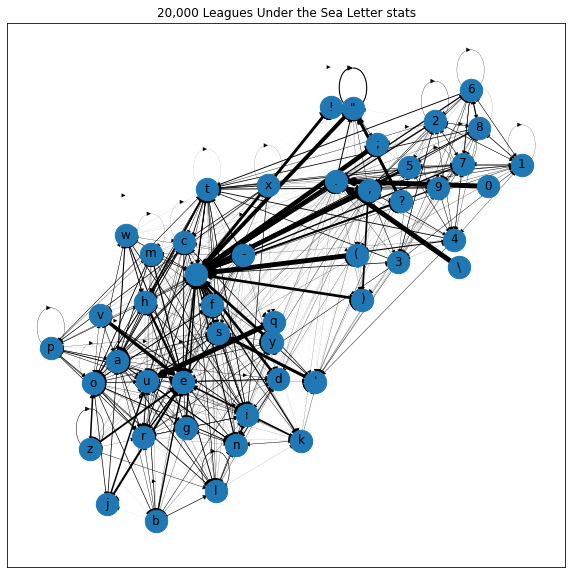

In [85]:
import networkx as nx
import matplotlib.pyplot as plt

# Нарисуем граф связей
G = nx.DiGraph()

fig = plt.figure(figsize=(10, 10))

G.add_weighted_edges_from(edges)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 500)
nx.draw_networkx_labels(G, pos)

for (node1, node2, edge_attr) in tqdm(G.edges(data=True)):
    nx.draw_networkx_edges(G, pos, edgelist=[(node1, node2)],width=edge_attr['weight'])

plt.title('20,000 Leagues Under the Sea Letter stats')
plt.show()